   zone_id  year  month  day      h1      h2      h3      h4      h5      h6  \
0        1  2004      1    1  16,853  16,450  16,517  16,873  17,064  17,727   
1        1  2004      1    2  14,155  14,038  14,019  14,489  14,920  16,072   
2        1  2004      1    3  14,439  14,272  14,109  14,081  14,775  15,491   
3        1  2004      1    4  11,273  10,415   9,943   9,859   9,881  10,248   
4        1  2004      1    5  10,750  10,321  10,107  10,065  10,419  12,101   

   ...     h15     h16     h17     h18     h19     h20     h21     h22  \
0  ...  13,518  13,138  14,130  16,809  18,150  18,235  17,925  16,904   
1  ...  16,127  15,448  15,839  17,727  18,895  18,650  18,443  17,580   
2  ...  13,507  13,414  13,826  15,825  16,996  16,394  15,406  14,278   
3  ...  14,207  13,614  14,162  16,237  17,430  17,218  16,633  15,238   
4  ...  13,845  14,350  15,501  17,307  18,786  19,089  19,192  18,416   

      h23     h24  
0  16,162  14,750  
1  16,467  15,258  
2  13,315  12,

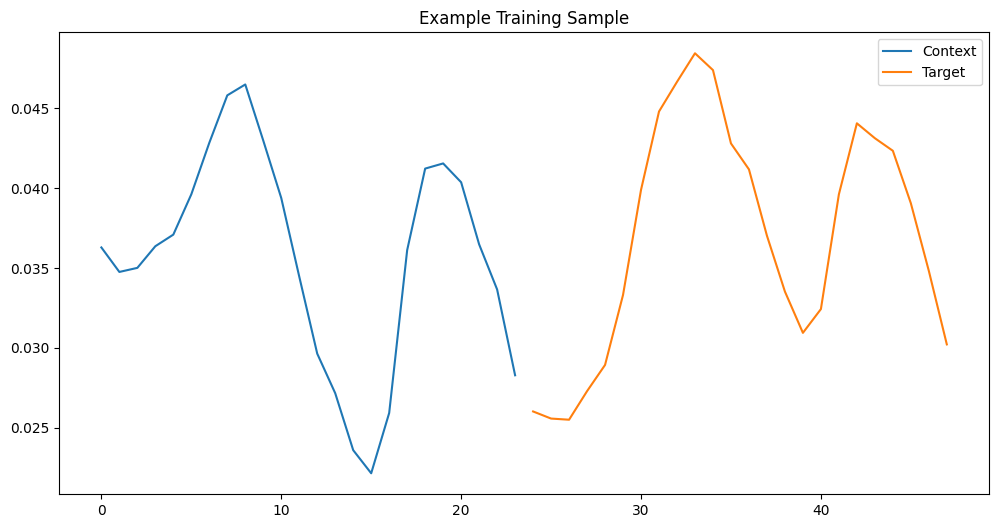

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from tqdm import tqdm
import math

# Load and preprocess the data
df = pd.read_csv("Load_demand_data.csv")

# Check the first few rows
print(df.head())

# Reshape the data to long format
df_long = df.melt(id_vars=['zone_id', 'year', 'month', 'day'],
                  value_vars=[f'h{i}' for i in range(1, 25)],
                  var_name='hour', value_name='value')

df_long['hour'] = df_long['hour'].str.extract('(\d+)').astype(int)
df_long['datetime'] = pd.to_datetime(df_long[['year', 'month', 'day']].astype(str).agg('-'.join, axis=1)) \
    + pd.to_timedelta(df_long['hour'] - 1, unit='h')
df_long = df_long.drop(columns=['year', 'month', 'day', 'hour'])
df_long = df_long[['zone_id', 'datetime', 'value']]
df_long = df_long.sort_values(by=['zone_id', 'datetime']).reset_index(drop=True)

print(df_long.head()) # To check if the data is cleaned

# Clean the 'value' column by removing commas and converting to float

if pd.api.types.is_numeric_dtype(df_long['value']):
    df_long['value'] = df_long['value'].astype(float) # If 'value' is of numeric type, simply convert it to float

else:
    df_long['value'] = df_long['value'].str.replace(',', '').astype(float) # If 'value' is not numeric, then assume it's string


# Normalize the 'value' column for each zone_id separately
scaler = MinMaxScaler(feature_range=(0, 1))
df_long['value_normalized'] = df_long.groupby('zone_id')['value'].transform(
    lambda x: scaler.fit_transform(x.values.reshape(-1, 1)).ravel()
)
# Check if the data is scaled
print(df_long.head())

# Create sequences for time series forecasting
def create_sequences(data, sequence_length, target_length):
    xs, ys = [], []
    for i in range(len(data) - sequence_length - target_length + 1):
        x = data[i:(i + sequence_length)]
        y = data[(i + sequence_length):(i + sequence_length + target_length)]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Define sequence and target lengths
sequence_length = 24  # Use 24 hours (1 day) as input sequence
target_length = 24    # Predict the next 24 hours (1 day)

# Prepare data for each zone_id
zone_ids = df_long['zone_id'].unique()
X_all, y_all = [], []

for zone_id in zone_ids:
    zone_data = df_long[df_long['zone_id'] == zone_id]['value_normalized'].values
    X, y = create_sequences(zone_data, sequence_length, target_length)
    X_all.append(X)
    y_all.append(y)

# Concatenate data from all zones
X_all = np.concatenate(X_all, axis=0)
y_all = np.concatenate(y_all, axis=0)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, shuffle=False)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Reshape X_train and X_test to match the expected input shape for models
X_train = X_train.unsqueeze(-1)  # Add feature dimension
X_test = X_test.unsqueeze(-1)    # Add feature dimension

# Create DataLoader for training and testing
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 4. Verify your data
print(f"Training data shape: {X_train.shape}")  # Should be (num_samples, context_length, 1)
print(f"Test data shape: {X_test.shape}")

context_length = sequence_length  # or 24, if you prefer hardcoding
pred_length = target_length       # or 24, similarly

# Plot example sample
plt.figure(figsize=(12, 6))
plt.plot(X_train[0].numpy(), label='Context')
plt.plot(range(context_length, context_length+pred_length),
         y_train[0].numpy(), label='Target')
plt.legend()
plt.title("Example Training Sample")
plt.show()

In [2]:

# ---------------------------- Positional Encoding ----------------------------
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0)]

# ---------------------------- Base Time Series Model ----------------------------
class BaseTimeSeriesModel(nn.Module):
    def __init__(self, input_dim, output_dim, pred_length, embed_dim=64):
        super().__init__()
        self.pred_length = pred_length
        self.embedding = nn.Linear(input_dim, embed_dim)
        self.pos_encoder = PositionalEncoding(embed_dim)
        self.fc_out = nn.Linear(embed_dim, output_dim)

    def forward(self, x):
        x = self.embedding(x)            # [B, T, D]
        x = x.transpose(0, 1)            # [T, B, D]
        x = self.pos_encoder(x)
        x = self.encode(x)
        x = x.transpose(0, 1)            # [B, T, D]
        return self.fc_out(x[:, -self.pred_length:, :])  # [B, pred_len, output_dim]

    def encode(self, x):
        raise NotImplementedError("Subclasses must implement encode()")

# ---------------------------- Transformer ----------------------------
class Transformer(BaseTimeSeriesModel):
    def __init__(self, *args, num_layers=3, num_heads=4, **kwargs):
        super().__init__(*args, **kwargs)
        encoder_layer = nn.TransformerEncoderLayer(d_model=self.embedding.out_features, nhead=num_heads)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

    def encode(self, x):
        return self.encoder(x)

# ---------------------------- Nonstationary Transformer ----------------------------
class NonstationaryTransformer(Transformer):
    def __init__(self, *args, num_layers=3, **kwargs):
        super().__init__(*args, num_layers=num_layers, **kwargs)
        self.norm = nn.LayerNorm(self.embedding.out_features)
        self.adapt_norm = nn.ModuleList([nn.LayerNorm(self.embedding.out_features) for _ in range(num_layers)])

    def encode(self, x):
        x = self.norm(x)
        for i, layer in enumerate(self.encoder.layers):
            x = self.adapt_norm[i](layer(x))
        return x

# ---------------------------- Reformer (Simulated Chunked Attention) ----------------------------
class ChunkedAttention(nn.Module):
    def __init__(self, embed_dim, num_heads, chunk_size):
        super().__init__()
        self.chunk_size = chunk_size
        self.attn = nn.MultiheadAttention(embed_dim, num_heads)
        self.norm = nn.LayerNorm(embed_dim)

    def forward(self, x):
        chunks = x.split(self.chunk_size, dim=0)
        outputs = []
        for chunk in chunks:
            out, _ = self.attn(chunk, chunk, chunk)
            outputs.append(self.norm(chunk + out))
        return torch.cat(outputs, dim=0)

class Reformer(BaseTimeSeriesModel):
    def __init__(self, *args, num_layers=3, num_heads=4, chunk_size=16, **kwargs):
        super().__init__(*args, **kwargs)
        self.attn_layers = nn.ModuleList([
            ChunkedAttention(self.embedding.out_features, num_heads, chunk_size)
            for _ in range(num_layers)
        ])

    def encode(self, x):
        for layer in self.attn_layers:
            x = layer(x)
        return x

# ---------------------------- Informer Model ----------------------------
class Informer(nn.Module):
    def __init__(self, input_dim, output_dim, pred_length, embed_dim=64, num_layers=3, num_heads=4):
        super().__init__()
        self.pred_length = pred_length
        self.embedding = nn.Linear(input_dim, embed_dim)  # Embedding the input features
        self.pos_encoder = PositionalEncoding(embed_dim)  # Positional Encoding

        # Transformer Encoder Layers
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.fc_out = nn.Linear(embed_dim, output_dim)  # Final output layer

    def forward(self, x):
        # Embed the input sequence
        x = self.embedding(x)  # (batch_size, seq_len, embed_dim)
        x = x.transpose(0, 1)  # (seq_len, batch_size, embed_dim) for transformer input
        x = self.pos_encoder(x)  # Add positional encoding

        # Pass through transformer encoder
        x = self.encoder(x)  # (seq_len, batch_size, embed_dim)

        x = x.transpose(0, 1)  # (batch_size, seq_len, embed_dim)

        # Slice the output to match the prediction length
        out = x[:, -self.pred_length:, :]  # (batch_size, pred_length, embed_dim)

        # Final output layer
        out = self.fc_out(out)  # (batch_size, pred_length, output_dim)

        return out

# ---------------------------- Autoformer ----------------------------
class DecompositionLayer(nn.Module):
    def __init__(self, kernel_size):
        super().__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=1, padding=0)

    def forward(self, x):
        num_of_pads = (self.kernel_size - 1) // 2
        front = x[:, 0:1, :].repeat(1, num_of_pads, 1)
        end = x[:, -1:, :].repeat(1, num_of_pads, 1)
        x_padded = torch.cat([front, x, end], dim=1)
        x_trend = self.avg(x_padded.permute(0, 2, 1)).permute(0, 2, 1)
        x_seasonal = x - x_trend
        return x_seasonal, x_trend

class Autoformer(nn.Module):
    def __init__(self, input_dim, output_dim, pred_length, embed_dim=64, num_layers=3, num_heads=4):
        super().__init__()
        self.pred_length = pred_length
        self.embedding = nn.Linear(input_dim, embed_dim)  # Ensure embedding dim is consistent
        self.pos_encoder = PositionalEncoding(embed_dim)  # Positional Encoding

        # Trend and Seasonal Blocks with consistent embedding dimensions
        self.trend_block = nn.Sequential(
            nn.Linear(embed_dim, embed_dim),
            nn.GELU(),
            nn.Linear(embed_dim, embed_dim),
            nn.LayerNorm(embed_dim)  # Ensures embedding dimension consistency
        )

        self.seasonal_block = nn.Sequential(
            nn.Linear(embed_dim, embed_dim),
            nn.GELU(),
            nn.Linear(embed_dim, embed_dim),
            nn.LayerNorm(embed_dim)  # Ensures embedding dimension consistency
        )

        # Attention layers with residuals and norm
        self.attn_layers = nn.ModuleList([
            nn.ModuleList([
                nn.MultiheadAttention(embed_dim, num_heads),
                nn.LayerNorm(embed_dim)  # Consistent embedding dimension
            ])
            for _ in range(num_layers)
        ])

        # Final output layer (ensuring output dimension matches)
        self.fc_out = nn.Linear(embed_dim, output_dim)

    def forward(self, x):
        x = self.embedding(x)                # [B, T, embed_dim]
        x = x.transpose(0, 1)                # [T, B, D]
        x = self.pos_encoder(x)

        # Decompose into trend and seasonal components
        trend = self.trend_block(x)
        seasonal = self.seasonal_block(x)
        x = trend + seasonal  # Combine trend and seasonal

        # Pass through attention layers
        for attn, norm in self.attn_layers:
            attn_out, _ = attn(x, x, x)  # Self-attention with query, key, and value all the same
            x = norm(x + attn_out)  # Residual connection with LayerNorm

        x = x.transpose(0, 1)                # [B, T, D]
        return self.fc_out(x[:, -self.pred_length:, :])  # [B, pred_len, output_dim]

# ---------------------------- Pyraformer ----------------------------
class PyramidAttentionBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, segment_len):
        super().__init__()
        self.segment_len = segment_len
        self.attn = nn.MultiheadAttention(embed_dim, num_heads)
        self.norm = nn.LayerNorm(embed_dim)

    def forward(self, x):
        segments = x.split(self.segment_len, dim=0)
        attn_outputs = []
        for seg in segments:
            attn_out, _ = self.attn(seg, seg, seg)
            attn_outputs.append(self.norm(seg + attn_out))
        return torch.cat(attn_outputs, dim=0)

class Pyraformer(BaseTimeSeriesModel):
    def __init__(self, *args, num_layers=3, num_heads=4, segment_len=12, **kwargs):
        super().__init__(*args, **kwargs)
        self.pyramid_layers = nn.ModuleList([
            PyramidAttentionBlock(self.embedding.out_features, num_heads, segment_len)
            for _ in range(num_layers)
        ])

    def encode(self, x):
        for layer in self.pyramid_layers:
            x = layer(x)
        return x


In [3]:

## Training Framework -----------------------------------------------------------

class Trainer:
    def __init__(self, model, pred_length, loss_process='ERM', constraint_level=None):
        self.model = model
        self.pred_length = pred_length
        self.loss_process = loss_process

        if loss_process in ['Constant', 'Exponential']:
            self.dual_vars = nn.Parameter(torch.zeros(pred_length), requires_grad=True)
            self.slack_vars = nn.Parameter(torch.zeros(pred_length), requires_grad=True)
            self.constraint_level = constraint_level

    def compute_losses(self, x, y_true):
        y_pred = self.model(x)

        # Compute the MSE loss (ERM)
        step_losses = torch.mean((y_pred - y_true)**2, dim=(0, 2))  # MSE per time step

        # If loss process is 'Constant', apply a constant penalty
        if self.loss_process == 'Constant':
            penalty = torch.sum(self.dual_vars)
            step_losses = torch.clamp(step_losses + penalty, max=1e6)

        # If loss process is 'Exponential', apply an exponential penalty
        elif self.loss_process == 'Exponential':

            # Calculate the penalty with a scaled exponential or a more controlled penalty
            alpha = 0.1  # Smoother exponential growth
            clamped_dual_vars = self.dual_vars.clamp(min=0, max=10) # Clamp dual variables to a maximum of 10
            penalty = torch.sum(torch.expm1(alpha * clamped_dual_vars)) / 100.0
            l2_penalty = 0.001 * torch.sum(self.dual_vars**2)  #  Add L2 penalty
            total_penalty = penalty + l2_penalty # Combine both penalty terms
            step_losses = torch.clamp(step_losses + total_penalty, max=1e6)  # Clamp the final step losses to prevent overflow

        return step_losses

    def predict(self, X):
        """Make predictions using the trained model."""
        self.model.eval()  # Set the model to evaluation mode
        with torch.no_grad():  # Disable gradient calculations during prediction
            predictions = self.model(X)  # Get predictions from the model
        return predictions.cpu().numpy()  # Convert predictions to NumPy array


    def train_step(self, x, y_true, epsilon=None, primal_optim=None, dual_optim=None, slack_optim=None):
        if self.loss_process == 'ERM':
            # Standard ERM training
            primal_optim.zero_grad()
            y_pred = self.model(x)
            loss = torch.mean((y_pred - y_true)**2)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0) # New
            primal_optim.step()
            return torch.mean((y_pred - y_true)**2, dim=(0, 2)).detach().cpu().numpy()

        else:
            # Constrained learning
            primal_optim.zero_grad()
            dual_optim.zero_grad()
            slack_optim.zero_grad()

            step_losses = self.compute_losses(x, y_true)

            # Compute Lagrangian
            lagrangian = torch.sum((self.dual_vars + 1/self.pred_length) * step_losses) - \
                        torch.sum(self.dual_vars * (epsilon + self.slack_vars)) + \
                        0.5 * torch.sum(self.slack_vars**2)

            lagrangian.backward()

            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)  # Clip gradients

            # Update parameters
            primal_optim.step()
            dual_optim.step()
            slack_optim.step()

            # Clamp dual and slack variables to prevent instability
            with torch.no_grad():
                self.dual_vars.data = torch.clamp(self.dual_vars.data, min=0, max=10)
                self.slack_vars.data = torch.clamp(self.slack_vars.data, min=0)

            return step_losses.detach().cpu().numpy()

    def train(self, train_loader, val_loader, epochs=10):
        # Initialize optimizers
        primal_optim = optim.Adam(self.model.parameters(), lr=1e-3)

        if self.loss_process != 'ERM':
            dual_optim = optim.Adam([self.dual_vars], lr=1e-4)
            slack_optim = optim.Adam([self.slack_vars], lr=1e-4)

            # Set epsilon based on constraint type
            if self.constraint_level is None:
                erm_losses = self._get_erm_losses(train_loader)
                erm_losses = torch.tensor(erm_losses)
                if self.loss_process == 'Constant':
                    epsilon = torch.ones(self.pred_length) * torch.median(erm_losses)
                elif self.loss_process == 'Exponential':
                    epsilon = torch.linspace(erm_losses.min(), erm_losses.max(), self.pred_length)
            else:
                epsilon = self.constraint_level
        else:
            dual_optim = None
            slack_optim = None
            epsilon = None

        train_loss_history = []
        val_loss_history = []

        for epoch in tqdm(range(epochs), desc=f"Training {self.model.__class__.__name__} with {self.loss_process}"):
            self.model.train()
            epoch_train_losses = []

            for x, y in train_loader:
                step_losses = self.train_step(x, y, epsilon, primal_optim, dual_optim, slack_optim)
                epoch_train_losses.append(step_losses)

            # Average losses across batches
            avg_train_loss = np.mean(epoch_train_losses, axis=0)
            train_loss_history.append(avg_train_loss)

            # Validation
            self.model.eval()
            val_losses = []
            with torch.no_grad():
                for x, y in val_loader:
                    val_loss = self.compute_losses(x, y).cpu().numpy()
                    val_losses.append(val_loss)

            avg_val_loss = np.mean(val_losses, axis=0)
            val_loss_history.append(avg_val_loss)

        return train_loss_history, val_loss_history

    def _get_erm_losses(self, loader):
        """Get baseline losses from ERM model"""
        temp_model = type(self.model)(self.model.embedding.in_features,
                                    self.model.fc_out.out_features,
                                    self.pred_length)
        optimizer = optim.Adam(temp_model.parameters())

        losses = []
        for x, y in loader:
            optimizer.zero_grad()
            y_pred = temp_model(x)
            # Calculate the total loss for the batch before calculating the mean per time step
            loss = torch.mean((y_pred - y)**2)
            loss.backward()
            optimizer.step()
            # Calculate the mean loss per time step after the backward pass
            step_losses = torch.mean((y_pred - y)**2, dim=(0, 2))
            losses.append(step_losses.detach().cpu().numpy()) # Changed step_loss to step_losses

        return np.mean(losses, axis=0)

    def compute_window_std(self, data_loader):
      self.model.eval()
      all_errors = []

      with torch.no_grad():
        for x, y_true in data_loader:
            y_pred = self.model(x)
            errors = y_pred - y_true  # shape: (batch, pred_len, features)
            errors = errors.detach().cpu()  # move to CPU
            all_errors.append(errors)

      all_errors = torch.cat(all_errors, dim=0)  # shape: (total_samples, pred_len, features)

      # Compute STD over prediction window (dim=1), then mean across samples/features
      window_std = torch.std(all_errors, dim=1)  # shape: (samples, features)
      avg_window_std = window_std.mean().item()  # scalar

      return avg_window_std


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
Training Transformer with ERM: 100%|██████████| 10/10 [27:07<00:00, 162.72s/it]
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
Training NonstationaryTransformer with Constant: 100%|██████████| 10/10 [26:20<00:00, 158.08s/it]
Training NonstationaryTransformer with Exponential: 100%|██████████| 10/10 [26:20<00:00, 158.10s/it]
Training Autoformer with Exponential: 100%|██████████| 10/10 [04:06<00:00, 24.64s/it]


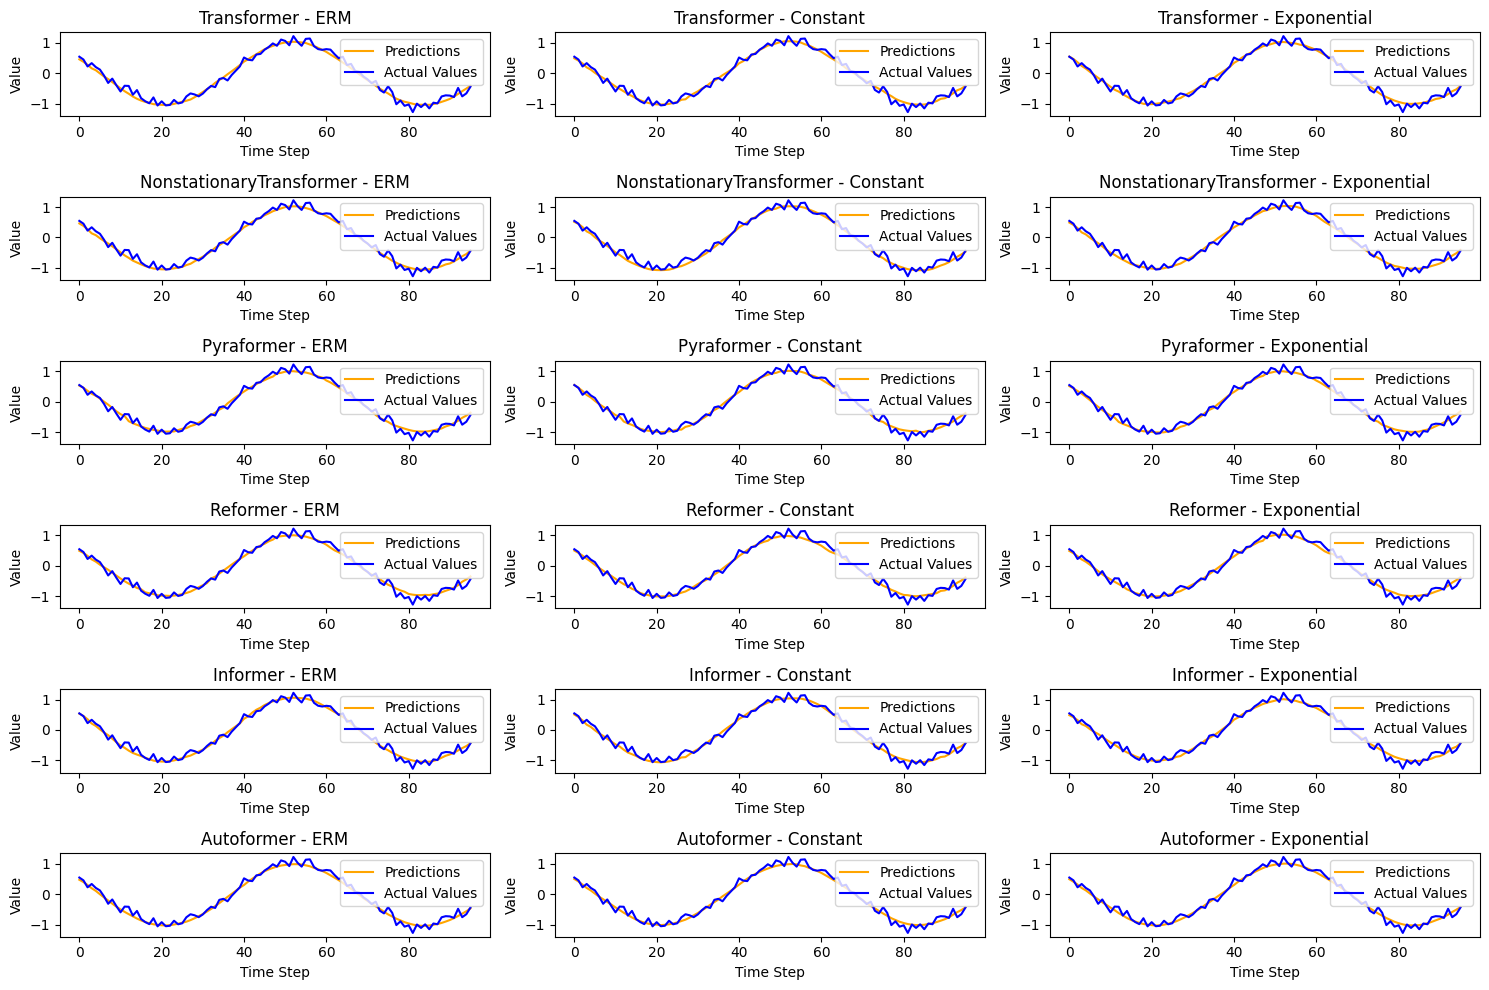

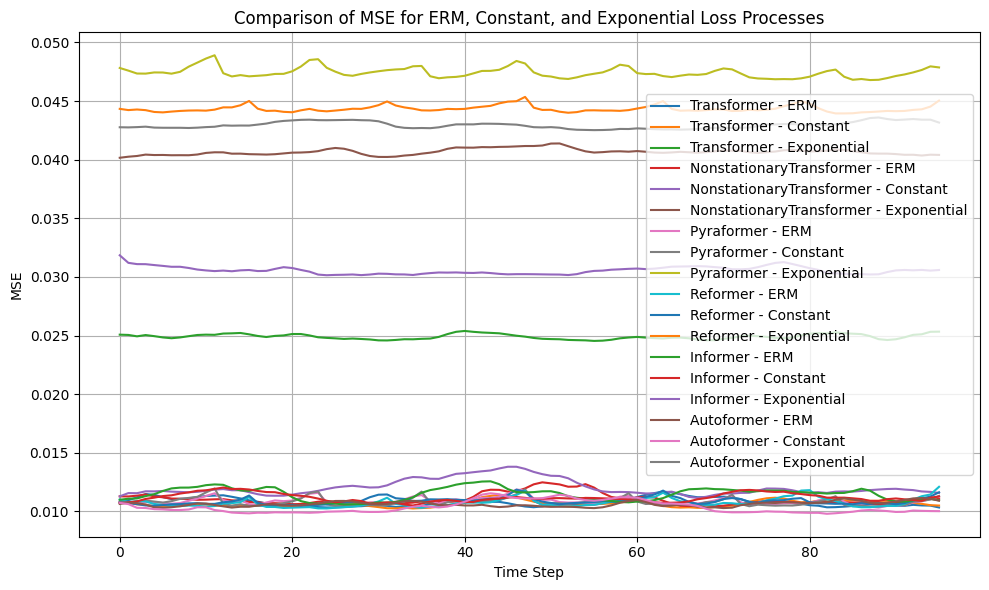

Transformer - ERM: Last MSE = 0.010335486382246017
Transformer - Constant: Last MSE = 0.010499667376279831
Transformer - Exponential: Last MSE = 0.02533208765089512
NonstationaryTransformer - ERM: Last MSE = 0.011061758734285831
NonstationaryTransformer - Constant: Last MSE = 0.011575835756957531
NonstationaryTransformer - Exponential: Last MSE = 0.04040481150150299
Pyraformer - ERM: Last MSE = 0.011273070238530636
Pyraformer - Constant: Last MSE = 0.011319081299006939
Pyraformer - Exponential: Last MSE = 0.04786683991551399
Reformer - ERM: Last MSE = 0.012098056264221668
Reformer - Constant: Last MSE = 0.011633760295808315
Reformer - Exponential: Last MSE = 0.04503917694091797
Informer - ERM: Last MSE = 0.010943436063826084
Informer - Constant: Last MSE = 0.011270245537161827
Informer - Exponential: Last MSE = 0.030589254572987556
Autoformer - ERM: Last MSE = 0.010914538986980915
Autoformer - Constant: Last MSE = 0.01002275850623846
Autoformer - Exponential: Last MSE = 0.0431635119020

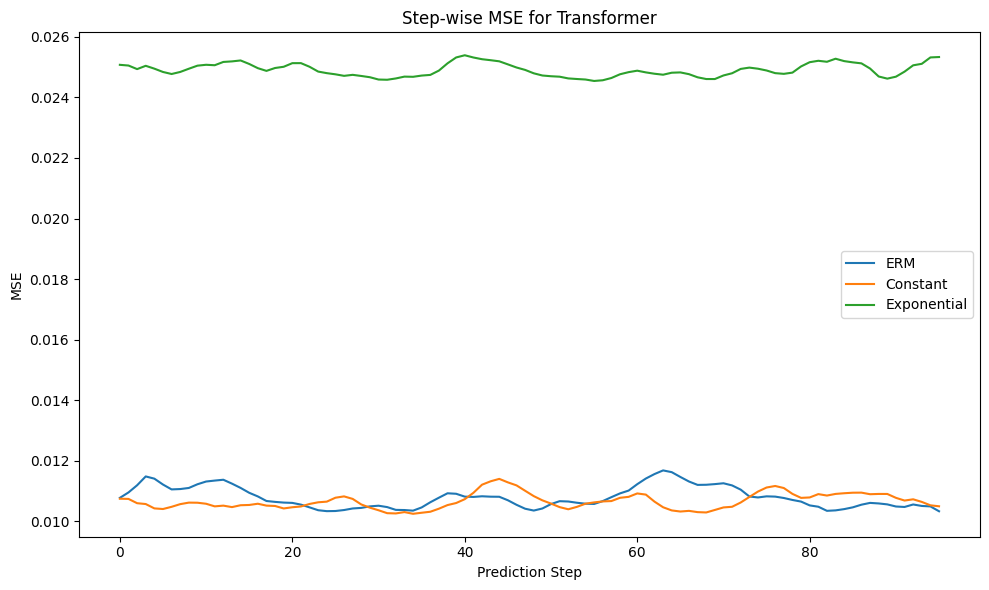


Transformer - ERM:
Predicted values for the first sample: [ 0.457734    0.37653834  0.27881598  0.16159296  0.09944768 -0.00529436
 -0.10601418 -0.18991745 -0.28915048 -0.3918211  -0.49410093 -0.58978945
 -0.6727753  -0.76492    -0.838164   -0.8958857  -0.93968797 -0.97461617
 -1.0146021  -1.0267665  -1.0376916  -1.0439622  -1.0310597  -1.0068316
 -0.97007275 -0.93640876 -0.90241987 -0.86219525 -0.78735816 -0.7034588
 -0.6140938  -0.52206826 -0.4307012  -0.31341076 -0.22292748 -0.13603178
 -0.03225869  0.0639784   0.16536342  0.26947114  0.38262963  0.46076465
  0.54557735  0.6241911   0.70955366  0.7882793   0.8505548   0.9012109
  0.9434358   0.983008    1.0122455   1.0295115   1.0353782   1.0286851
  1.012533    0.9949314   0.9445575   0.8972517   0.83559567  0.76940966
  0.7023287   0.6158155   0.53343076  0.44644153  0.35170266  0.26899698
  0.16388744  0.07232867 -0.03531385 -0.13389748 -0.22559941 -0.30894828
 -0.41170952 -0.5065071  -0.5891093  -0.66397357 -0.7536218  -0.83540

In [4]:
## Data Preparation and Experiment ----------------------------------------------

def prepare_data(data, context_length, pred_length):
    """Create sequences for time series forecasting"""
    sequences = []
    targets = []
    for i in range(len(data) - context_length - pred_length + 1):
        sequences.append(data[i:i+context_length])
        targets.append(data[i+context_length:i+context_length+pred_length])
    return np.array(sequences), np.array(targets)

def run_experiment(models, loss_processes, data, context_length, pred_length, epochs=10):
    # Prepare data
    X, y = prepare_data(data, context_length, pred_length)

    # Split into train and validation
    split_idx = int(0.8 * len(X))
    X_train, y_train = X[:split_idx], y[:split_idx]
    X_val, y_val = X[split_idx:], y[split_idx:]

    # Convert to tensors
    X_train = torch.FloatTensor(X_train)
    y_train = torch.FloatTensor(y_train)
    X_val = torch.FloatTensor(X_val)
    y_val = torch.FloatTensor(y_val)

    # Create dataloaders
    train_dataset = TensorDataset(X_train, y_train)
    val_dataset = TensorDataset(X_val, y_val)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32)

    results = {}

    for model_class in models:
        for process in loss_processes:
            # Initialize model and trainer
            model = model_class(input_dim=1, output_dim=1, pred_length=pred_length)
            trainer = Trainer(model, pred_length, loss_process=process)

            # Train
            train_loss, val_loss = trainer.train(train_loader, val_loader, epochs=epochs)

            # Store results
            key = f"{model_class.__name__}_{process}"
            results[key] = {
                'train_loss': train_loss,
                'val_loss': val_loss,
                'final_step_loss': val_loss[-1],  # Final validation step losses
                'predictions': trainer.predict(X_val),  # Predictions for validation set
                'val_loss_per_step': val_loss[-1],
                #'window_std': window_std,
                'window_std': trainer.compute_window_std(val_loader)

            }

    return results

def plot_results(results, pred_length, X_val, y_val):
    """Plot the step-wise losses for all models and processes"""
    plt.figure(figsize=(15, 10))
    num_plots = len(results)
    num_cols = 3
    num_rows = (num_plots + num_cols - 1) // num_cols

    for i, (key, result) in enumerate(results.items()):
        model_name, process = key.split('_')
        plt.subplot(num_rows, num_cols, i+1)

        # Get the predictions and actual values
        predictions = result['predictions']
        actual_values = y_val.numpy()

        # Plot first prediction and corresponding actual values
        plt.plot(np.arange(pred_length), predictions[0, :, 0], label="Predictions", color='orange')
        plt.plot(np.arange(pred_length), actual_values[0, :, 0], label="Actual Values", color='blue')

        #plt.plot(result['final_step_loss'], label=process)
        plt.title(f"{model_name} - {process}")
        plt.xlabel('Time Step')
        plt.ylabel('Value')
        plt.legend()
        #plt.ylim(0, np.max(result['final_step_loss']) * 1.2)

    plt.tight_layout()
    plt.show()

def print_last_mse(results):
    """Print the last MSE value for all models and loss processes"""
    for key, result in results.items():
        model_name, process = key.split('_')
        print(f"{model_name} - {process}: Last MSE = {result['final_step_loss'][-1]}")


def plot_mse_comparison(results, pred_length):
    """Plot the MSE for ERM, Constant, and Exponential loss processes on the same plot."""
    plt.figure(figsize=(10, 6))

    # Loop through results and plot MSE for each loss process
    for key, result in results.items():
        model_name, process = key.split('_')

        if process in ['ERM', 'Constant', 'Exponential']:
            # Extract the MSE values (final step losses)
            mse_values = result['val_loss'][-1]  # Using the final validation loss as MSE for the plot
            plt.plot(np.arange(pred_length), mse_values, label=f"{model_name} - {process}")

    # Adding labels and title
    plt.xlabel('Time Step')
    plt.ylabel('MSE')
    plt.title('Comparison of MSE for ERM, Constant, and Exponential Loss Processes')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_stepwise_mse_for_model(results, model_name, pred_length):
    plt.figure(figsize=(10, 6))

    for process in ['ERM', 'Constant', 'Exponential']:
        key = f"{model_name}_{process}"
        if key in results:
            step_mse = results[key]['final_step_loss']
            plt.plot(range(pred_length), step_mse, label=process)
        else:
            print(f"[Warning] Missing per-step MSE for {key}, skipping.")

    plt.title(f"Step-wise MSE for {model_name}")
    plt.xlabel("Prediction Step")
    plt.ylabel("MSE")
    plt.legend()
    plt.tight_layout()
    plt.show()


## Main Execution ---------------------------------------------------------------

def main():
    # Set random seeds for reproducibility
    np.random.seed(42)
    torch.manual_seed(42)

    # Generate synthetic time series data
    time = np.arange(0, 1000, 0.1)
    data = np.sin(time) + 0.1 * np.random.randn(len(time))
    data = data.reshape(-1, 1)  # (n_samples, n_features)

    # Experiment parameters
    context_length = 96
    pred_length = 96
    epochs = 10

    # Models to test
    models = [Transformer, NonstationaryTransformer, Pyraformer, Reformer, Informer, Autoformer]
    #models = [Transformer]
    loss_processes = ['ERM', 'Constant', 'Exponential']
    model_names = [model_class.__name__ for model_class in models] # Extract model name

    # Run experiment
    results = run_experiment(models, loss_processes, data, context_length, pred_length, epochs)

    # Get X_val and y_val from the run_experiment function
    X, y = prepare_data(data, context_length, pred_length)
    split_idx = int(0.8 * len(X))
    X_val, y_val = X[split_idx:], y[split_idx:]
    X_val = torch.FloatTensor(X_val)
    y_val = torch.FloatTensor(y_val)


    # Plot results
    plot_results(results, pred_length,  X_val, y_val)
    plot_mse_comparison(results, pred_length)
    # Print last MSE values for all models and loss processes
    print_last_mse(results)

    plot_stepwise_mse_for_model(results, model_name=model_names[0], pred_length=pred_length)


    # Print predictions and actual values for all model-loss combinations
    for key, result in results.items():
        model_name, process = key.split('_')
        predictions = result['predictions']
        actual_values = y_val.numpy()
        print(f"\n{model_name} - {process}:")
        print(f"Predicted values for the first sample: {predictions[0, :, 0]}")
        print(f"Actual values for the first sample: {actual_values[0, :, 0]}")

    print("\n=== Window STD of Prediction Errors ===")
    for key, result in results.items():
      model_name, process = key.split('_')
      std_val = result.get('window_std', None)
      if std_val is not None:
        print(f"{model_name} - {process}: Window STD = {std_val:.4f}")



if __name__ == "__main__":
    main()